We re-create numerical artefacts in the implementation of GPR with a periodic kernel for forward prediction. 
We consider a simple truth trajectory given by a deterministic sine curve. Next, we configure the GPRP algorithm and plot predictions. 

To get started, I import some python software I will need:

In [1]:
import sys
sys.path.append('../../../../../')
from plot_tools.fig_preamble import * # imports numpy, matplotlib, Py2PDF, plot_helper_funcs, plot_figstyle_sheet
import GPy


from gpr.common import get_data, simple_unlearnable_sine
from data_tools.load_raw_cluster_data import LoadExperiment as le
from plot_tools.plot_figstyle_sheet import color_pallete, predmarker, COLOURDICT, STYLEDICT
from analysis_tools.common import sqr_err

/home/riddhisw/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:
/home/riddhisw/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1182: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markeredgecolor != ec:


I also set up filepaths for saving data

In [2]:
ver=0
datapath = '../../../../DATA_v'+str(ver)+'_/' #v'+str(ver)+'/DATA_v'+str(ver)+'/'
savefig2 = '../svg/paper_v0_'
figdata = '../svg/fig_data/paper_v0_'
figname2 = 'GPR_new_BR'

Now, let's consider how to configure the GPRP algorithm with limited apriori information about the truth.
In our application, let $\Delta t$ represent the shortest possible time-spacing in our procedure between two sequential measurements from an experiment, and let $\Delta t N_T$ represent the longest possible time spacing observed in the measurement record. 

We use physical arguments to link the periodicity and the lengthscale to the longest and shortest timescales of the observed system during training. In configuring a GPR algorithm, one decides or optimises $\omega_0^{(B)}$. For the physically set paramter, $\Delta t$ in our procedure, a classical analysis suggests that one needs $2 \pi /(\Delta t \omega_0^{(B)})$ for a computational method to resolve Fourier components of true noise to an order $\omega_0^{(B)}$. Further, any changes in the continuous process below $\Delta t$ will not be observed. These reasons lead us to propose the following initial conditions for kernel hyperparameters at the outset of a procedure:, namely:

    - p = N_train
    - l = 3 * Delta T 
    


In [3]:
# Set experimental parameters
n_train = 2000
Delta_T = 0.001
n_predict = 100
n_testbefore=50

In [4]:
# Set initial starting values for L-BFGS-B OPtimiser in GPy
sigma_0 = 1.0
R_0 =  1.0

In [5]:
# Set length scale and periodicity initial values for L-BFGS-B OPtimiser in GPy
length_scale_0 = 3.0*Delta_T
period_0 = 2000.0

true = 9.0/3.0
multipler = 7. # must be an integer
spacing = true / multipler
steps = (1./ spacing)/ 0.001
print steps
print spacing

print basis
print true / (1./(2000*0.001)) # integer

We now implement optimised GPRP model but with constrained periodicities

In [48]:
10**4

10000

In [6]:
total_runs = 50
periodicities = ((2000, 2001), (0, 10**3), (10**3, 10**4), (10**4, 10**5), (None, None))

In [7]:
pred_list= np.zeros((len(periodicities), total_runs, n_predict+n_testbefore))
opt_list = np.zeros((len(periodicities), total_runs, 4))
truth_list= np.zeros((len(periodicities), total_runs, n_predict+n_testbefore))
failed_runs_list = np.zeros((len(periodicities), total_runs))

In [8]:
dataobject = le(19, 5, 
                skip = 1,
                GPRP_load='No', GPRP_path = './',
                LKFFB_load = 'Yes', LKFFB_path = datapath,
                AKF_load='No', AKF_path = './',
                LSF_load = 'No', LSF_path = './')

LKFFB: Data Loaded? Yes


In [9]:
for idx_run in xrange(total_runs): 

    X, Y, TestX, truth, msmts = get_data(dataobject, points=2000, randomize='y')
  
    for idx_per in xrange(len(periodicities)):        
        
        # Reset
        kernel_per=0
        gauss=0
        exact=0
        m1=0

        
        # Built model
        kernel_per = GPy.kern.StdPeriodic(1, period=period_0, variance=sigma_0, 
                                          lengthscale=length_scale_0)
        gauss = GPy.likelihoods.Gaussian(variance=R_0)
        exact = GPy.inference.latent_function_inference.ExactGaussianInference()
        m1 = GPy.core.GP(X=X, Y=Y, kernel=kernel_per, likelihood=gauss, inference_method=exact)

        
        # Add constraints        
        if idx_per != len(periodicities)-1: # last condition
            print("Peridocity is constrained...")
            m1.std_periodic.period.constrain_bounded(periodicities[idx_per][0], periodicities[idx_per][1])
            

        print("Optimise GPRP for:", idx_per, idx_run)
        print(m1)
        
        try:
            m1.optimize(optimizer=None, messages=False)
            opt_list[idx_per, idx_run, :] = [m1.std_periodic.period[0], m1.std_periodic.lengthscale[0], m1.std_periodic.variance[0], gauss.variance[0]]
            pred_list[idx_per, idx_run, :] = m1.predict(TestX)[0].flatten()
            print("Optimisation complete!")
            print(m1)

        except:
            opt_list[idx_per, idx_run, :] = np.zeros(4)
            pred_list[idx_per, idx_run, :] = np.zeros(int(TestX.shape[0]))
            failed_runs_list[idx_per, idx_run] = idx_run
            print("Unexpected error:", sys.exc_info()[0])
            print("Failed run", idx_run)

        truth_list[idx_per, idx_run, :] = truth[int(TestX[0]):]
        
        np.savez(figdata+figname2,
                 truth_list=truth_list, 
                 pred_list=pred_list,
                 opt_list=opt_list, 
                 failed_runs_list=failed_runs_list)


 ../../../../../gpr/common.py:66: VisibleDeprecationWarning:using a non-integer number instead of an integer will result in an error in the future
 ../../../../../gpr/common.py:67: VisibleDeprecationWarning:using a non-integer number instead of an integer will result in an error in the future


Peridocity is constrained...
('Optimise GPRP for:', 0, 0)

Name : gp
Objective : 154958413.504
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                       |   value  |   constraints   |  priors
  std_periodic.variance     |     1.0  |       +ve       |        
  std_periodic.period       |  2000.0  |  2000.0,2001.0  |        
  std_periodic.lengthscale  |   0.003  |       +ve       |        
  Gaussian_noise.variance   |     1.0  |       +ve       |        
Optimisation complete!

Name : gp
Objective : 14242.2469152
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                       |            value  |   constraints   |  priors
  std_periodic.variance     |    862783.756191  |       +ve       |        
  std_periodic.period       |           2000.0  |  2000.0,2001.0  |        
  std_periodic.lengthscale  |  0.0137623756107  |       +ve       |        
  Gaussian_noise.variance 

 /home/riddhisw/anaconda2/lib/python2.7/site-packages/GPy/kern/src/standard_periodic.py:113: RuntimeWarning:overflow encountered in square
 /home/riddhisw/anaconda2/lib/python2.7/site-packages/GPy/kern/src/standard_periodic.py:132: RuntimeWarning:overflow encountered in square
 /home/riddhisw/anaconda2/lib/python2.7/site-packages/GPy/kern/src/standard_periodic.py:134: RuntimeWarning:divide by zero encountered in divide
 /home/riddhisw/anaconda2/lib/python2.7/site-packages/GPy/kern/src/standard_periodic.py:134: RuntimeWarning:invalid value encountered in multiply
 /home/riddhisw/anaconda2/lib/python2.7/site-packages/GPy/kern/src/standard_periodic.py:136: RuntimeWarning:divide by zero encountered in divide
 /home/riddhisw/anaconda2/lib/python2.7/site-packages/GPy/kern/src/standard_periodic.py:136: RuntimeWarning:invalid value encountered in divide
 /home/riddhisw/anaconda2/lib/python2.7/site-packages/GPy/kern/src/standard_periodic.py:144: RuntimeWarning:invalid value encountered in multi

Optimisation complete!

Name : gp
Objective : 367722479.278
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                       |            value  |  constraints  |  priors
  std_periodic.variance     |    1.00557320301  |      +ve      |        
  std_periodic.period       |    285.594992872  |  0.0,1000.0   |        
  std_periodic.lengthscale  |  0.0030136602204  |      +ve      |        
  Gaussian_noise.variance   |    1.04651621674  |      +ve      |        
Peridocity is constrained...
('Optimise GPRP for:', 2, 0)

Name : gp
Objective : 154958413.504
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                       |   value  |   constraints    |  priors
  std_periodic.variance     |     1.0  |       +ve        |        
  std_periodic.period       |  2000.0  |  1000.0,10000.0  |        
  std_periodic.lengthscale  |   0.003  |       +ve        |        
  Gaussian_noise.varian

 /home/riddhisw/anaconda2/lib/python2.7/site-packages/GPy/kern/src/standard_periodic.py:136: RuntimeWarning:overflow encountered in divide
 /home/riddhisw/anaconda2/lib/python2.7/site-packages/paramz/transformations.py:106: RuntimeWarning:invalid value encountered in greater
 /home/riddhisw/anaconda2/lib/python2.7/site-packages/paramz/transformations.py:111: RuntimeWarning:invalid value encountered in greater


('Unexpected error:', <class 'numpy.linalg.linalg.LinAlgError'>)
('Failed run', 0)
('Optimise GPRP for:', 4, 0)

Name : gp
Objective : 154958413.504
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                       |   value  |  constraints  |  priors
  std_periodic.variance     |     1.0  |      +ve      |        
  std_periodic.period       |  2000.0  |      +ve      |        
  std_periodic.lengthscale  |   0.003  |      +ve      |        
  Gaussian_noise.variance   |     1.0  |      +ve      |        


 /home/riddhisw/anaconda2/lib/python2.7/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


Optimisation complete!

Name : gp
Objective : 14773.6411401
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                       |            value  |  constraints  |  priors
  std_periodic.variance     |    118798.714407  |      +ve      |        
  std_periodic.period       |    1959.62750846  |      +ve      |        
  std_periodic.lengthscale  |  0.0106766672119  |      +ve      |        
  Gaussian_noise.variance   |    120207.858363  |      +ve      |        
Peridocity is constrained...
('Optimise GPRP for:', 0, 1)

Name : gp
Objective : 149537098.044
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                       |   value  |   constraints   |  priors
  std_periodic.variance     |     1.0  |       +ve       |        
  std_periodic.period       |  2000.0  |  2000.0,2001.0  |        
  std_periodic.lengthscale  |   0.003  |       +ve       |        
  Gaussian_noise.variance  

 /home/riddhisw/anaconda2/lib/python2.7/site-packages/GPy/kern/src/standard_periodic.py:112: RuntimeWarning:overflow encountered in divide
 /home/riddhisw/anaconda2/lib/python2.7/site-packages/GPy/kern/src/standard_periodic.py:113: RuntimeWarning:invalid value encountered in sin


Optimisation complete!

Name : gp
Objective : 19713.3794962
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                       |             value  |  constraints  |  priors
  std_periodic.variance     |     14056.3703318  |      +ve      |        
  std_periodic.period       |     5672.58475352  |      +ve      |        
  std_periodic.lengthscale  |  0.00210262866218  |      +ve      |        
  Gaussian_noise.variance   |     12772.3711181  |      +ve      |        
Peridocity is constrained...
('Optimise GPRP for:', 0, 7)

Name : gp
Objective : 158568644.408
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                       |   value  |   constraints   |  priors
  std_periodic.variance     |     1.0  |       +ve       |        
  std_periodic.period       |  2000.0  |  2000.0,2001.0  |        
  std_periodic.lengthscale  |   0.003  |       +ve       |        
  Gaussian_noise.varia

('For periodicity index, ', 0, ', total no. of failed runs is:', 0)
('For periodicity index, ', 1, ', total no. of failed runs is:', 25)
('For periodicity index, ', 2, ', total no. of failed runs is:', 4)
('For periodicity index, ', 3, ', total no. of failed runs is:', 23)


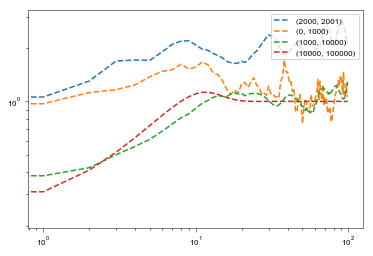

In [229]:
forecastng_errors = np.zeros(( len(periodicities), total_runs, n_predict ))
bayes_pred_risk = np.zeros(( len(periodicities), n_predict ))




plt.figure()
labels = ['k=0', 'k=70','k=10^2', 'k=10^4', 'k=10^6']


for idx_per in xrange(len(periodicities)-1):
    
    remove_runs = failed_runs_list[idx_per][(failed_runs_list[idx_per]>0)] 
    print("For periodicity index, ", idx_per, ", total no. of failed runs is:", remove_runs.shape[0])
    
    for case in xrange(total_runs):
        
        forecastng_errors[idx_per, case, :] = sqr_err(pred_list[idx_per, case, n_testbefore:], 
                                                      truth_list[idx_per, case, n_testbefore:])
        
    prd_zero = np.mean(np.delete(truth_list[idx_per]**2, 
                                 remove_runs, axis=0), 
                       axis=0)[n_testbefore:]
    
    bayes_pred_risk[idx_per, :] = np.mean(np.delete(forecastng_errors[idx_per, :, :], 
                                                    remove_runs, axis=0),
                                          axis=0) / prd_zero
    
    plt.plot(np.arange(n_predict), bayes_pred_risk[idx_per],'--',  label=str(periodicities[idx_per]))
    
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=1)
plt.show()

np.savez(figdata+figname2+'riskanalysis', 
         bayes_pred_risk=bayes_pred_risk, 
         periodicities=periodicities)


In [148]:
'''
idx_var:
0 - period of kernel
1 - lengthscale of kernel
2 - process noise variance
4 - msmt noise variance
d
'''
run_ratio = np.zeros((len(periodicities), total_runs, 4))

for idx_var in xrange(4):
    for idx_per in xrange(len(periodicities)):

        remove_runs = failed_runs_list[idx_per][(failed_runs_list[idx_per]>0)]
        length = total_runs-remove_runs.shape[0]
        run_ratio[idx_per, 0:length, idx_var] = np.delete(opt_list[idx_per, :, idx_var], remove_runs, axis=0) / np.delete(opt_list[idx_per, :, 0], remove_runs, axis=0)

np.savez(figdata+figname2+'riskanalysis', 
         bayes_pred_risk=bayes_pred_risk, 
         periodicities=periodicities, 
         run_ratio=run_ratio)


 /home/riddhisw/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning:invalid value encountered in divide


In [147]:
np.isfinite(run_ratio)

array([[[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ Tr

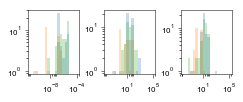

In [228]:
gs = gridspec.GridSpec(1,3,
                       left=0.15, right=0.985, 
                       top=0.85, bottom=0.1, 
                       wspace=0.5, hspace=0.2)

fig2 = plt.figure(figsize=(cm2inch(8.6),cm2inch(3)))

bins_ = np.logspace(-11, -4, 20)

idx_var=0
for idx_var in [1,2,3]:
    
    vars()['ax_'+str(idx_var)] = fig2.add_subplot(gs[0, idx_var-1])
    
    idx_per=0
    for idx_per in [2, 3, 4]:#xrange(len(periodicities)):
        
        remove_runs = failed_runs_list[idx_per][(failed_runs_list[idx_per]>0)]
        length = total_runs-remove_runs.shape[0]
        cleaned_data = run_ratio[idx_per, 0:length, idx_var][~np.isnan(run_ratio[idx_per, 0:length, idx_var])]
        
        if idx_var > 1:
            bins_ = np.logspace(-2, 5, 20)
            
        vars()['ax_'+str(idx_var)].hist(cleaned_data, bins=bins_, alpha=0.25, label=str(idx_per))
        vars()['ax_'+str(idx_var)].set_xscale('log')
        vars()['ax_'+str(idx_var)].set_yscale('log')

#vars()['ax_'+str(idx_var)].legend(loc=0)
plt.show()

 /home/riddhisw/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning:invalid value encountered in divide


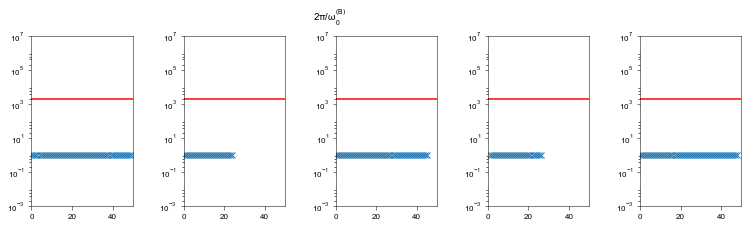

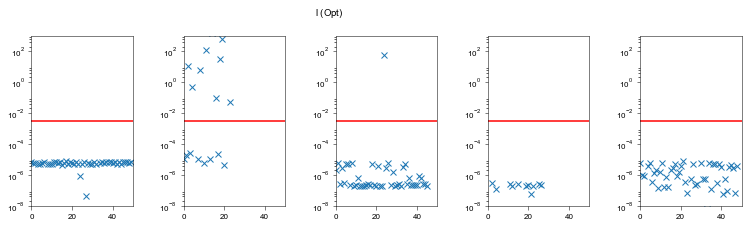

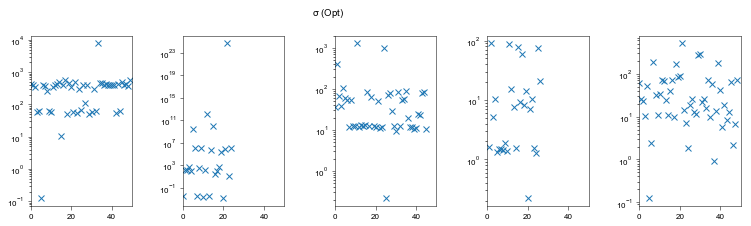

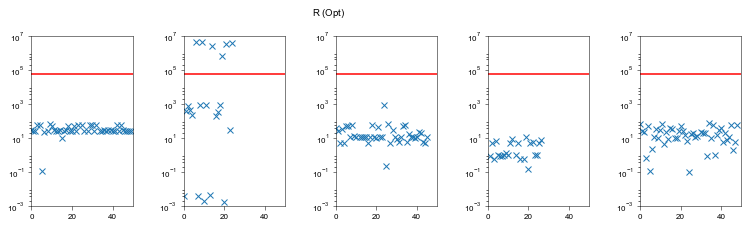

In [140]:
'''
0 - period of kernel
1 - lengthscale of kernel
2 - process noise variance
4 - msmt noise variance

'''
titles = ['$2 \pi / \omega_0^{(B)}$', '$l$ (Opt)', '$\sigma$ (Opt)', '$R$ (Opt)'  ]

for idx_var in [0, 1, 2, 3]:
    
    gs = gridspec.GridSpec(1, 5,
                           left=0.15, right=0.985, 
                           top=0.85, bottom=0.1, 
                           wspace=0.5, hspace=0.2)

    fig2 = plt.figure(figsize=(cm2inch(30),cm2inch(8)))
    fig2.suptitle(titles[idx_var])

    for idx_per in xrange(len(periodicities)):

        remove_runs = failed_runs_list[idx_per][(failed_runs_list[idx_per]>0)]
        remaining_runs = np.delete(opt_list[idx_per, :, idx_var], remove_runs, axis=0) / np.delete(opt_list[idx_per, :, 0], remove_runs, axis=0)

        ax = fig2.add_subplot(gs[0, idx_per]) 
        
        
        ax.plot(np.arange(remaining_runs.shape[0]), remaining_runs, 'x')
        
        if idx_var ==0:
            ax.axhline(y=n_train, c='r', label='Fourier Res.')
            ax.set_ylim([10**(-3), 10**7])
        
        if idx_var ==1:
            ax.axhline(y=3*Delta_T, c='r', label='$3\Delta t$')
            ax.set_ylim([10**(-8), 10**3])
            
        if idx_var ==3:
            ax.axhline(y=dataobject.LKFFB_msmt_noise_variance**2, c='r', label='$R$')
            ax.set_ylim([10**(-3), 10**7])
        
        if idx_var ==4:   
            ax.set_ylim([10**(-3), 10**7])
        #ax.set_title(str(periodicities[idx_per]))
        #ax.set_xscale('log')
        
        ax.set_yscale('log')      
        ax.set_xlim([0, 50])

    plt.show()